In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/cats-and-dogs-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cats-and-dogs-image-classification' dataset.
Path to dataset files: /kaggle/input/cats-and-dogs-image-classification


Found 557 files belonging to 2 classes.
Using 446 files for training.
Found 557 files belonging to 2 classes.
Using 111 files for validation.
Classes: ['cats', 'dogs']
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.5486 - loss: 2.8848 - val_accuracy: 0.5135 - val_loss: 0.7102
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6049 - loss: 3.0093 - val_accuracy: 0.5135 - val_loss: 0.7280
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6050 - loss: 2.9256 - val_accuracy: 0.4865 - val_loss: 2.1050
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6442 - loss: 3.2020 - val_accuracy: 0.5495 - val_loss: 0.6858
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6553 - loss: 2.6664 - val_accuracy: 0.5135 - val_loss: 1.2479
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6754 - loss: 2.0790 - val_accuracy: 0.4955 - val_loss: 1.0678
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6715 

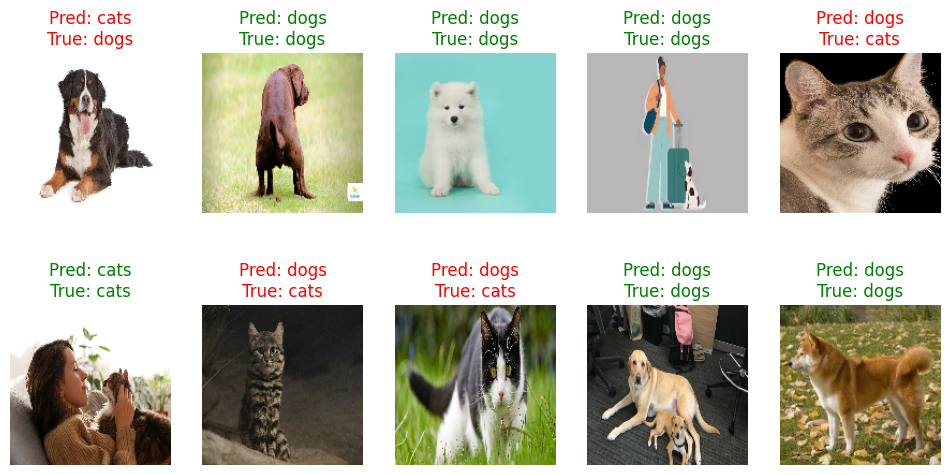

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ==============================
# Load dataset
# ==============================
train_dir = "/kaggle/input/cats-and-dogs-image-classification/train"

img_size = (150, 150)
batch_size = 32

# Training dataset with validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ==============================
# Data augmentation
# ==============================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# ==============================
# Build CNN model (from scratch)
# ==============================
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),

    # Convolution + Pooling blocks
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    # Flatten + Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# ==============================
# Compile model
# ==============================
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ==============================
# Early stopping
# ==============================
#early_stop = keras.callbacks.EarlyStopping(
#    monitor='val_loss',
#    patience=5,
#    restore_best_weights=True
#)

# ==============================
# Train model
# ==============================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    #callbacks=[early_stop]
)

# ==============================
# Plot predictions on validation
# ==============================
plt.figure(figsize=(12, 6))
for images, labels in val_ds.take(1):   # take one batch
    predictions = model.predict(images)
    for i in range(10):   # show first 10
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred = "dogs" if predictions[i] > 0.5 else "cats"
        true = class_names[labels[i]]

        color = "green" if pred == true else "red"
        plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
        plt.axis("off")
plt.show()
